In [1]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import torch.nn.init as init
import numpy as np
from opt_einsum import contract, contract_path
import sys
sys.path.insert(0, '/home/akiva/FCNX-Ensembling')
from FCN3Network import FCN3NetworkEnsembleErf
device = 'cuda:1'


# 2. Generate Data
input_size = 25
hidden_size = 250
output_size = 1
num_samples = 30
epochs = 100_000_000 # You might increase this with a decaying LR

k = 1.0
t = 2 * k # Temperature for Langevin (currently unused in pure GD, but defined)

# --- Learning Rate Schedule Parameters ---
import math as mt
ens = 50
T = 800_000
lrA = 1e-8 / num_samples
lrB = (1.0 / 3) * lrA / num_samples 
beta =  mt.log(lrA / lrB) / T

print(lrA * mt.exp(-beta * 1000))

# ------------------------------------------
# Set the default dtype to float64
torch.set_default_dtype(torch.float64)

device = torch.device("cpu")
# Set seeds as constants
DATA_SEED = 613
MODEL_SEED = 26
LANGEVIN_SEED = 480

3.314636757562325e-10


In [2]:


# Seed for data
torch.manual_seed(DATA_SEED)
X = torch.randn((num_samples, input_size), dtype=torch.float64).to(device)
Y = X[:,0].unsqueeze(-1).to(device)

# Seed for model
torch.manual_seed(MODEL_SEED)

model = FCN3NetworkEnsembleErf(input_size, hidden_size, hidden_size,
                                num_samples,
                                 ens=ens,
                                 weight_initialization_variance=(1/input_size, 1.0/hidden_size, 1.0/(hidden_size**2))).to(device)
# file = '/home/akiva/gpnettrain/P_20_D_20_N_400_epochs_2000000_lrA_5.00e-08_time_20250716_170626'
# file = '/home/akiva/experimental_results/fcn3/GP_P_20_D_20_N_400_epochs_2000000_lrA_5.00e-10_time_20250713_131139'
file = '/home/akiva/gpnettrain/P_20_D_20_N_300_epochs_6500000_lrA_5.00e-07_time_20250721_124037'
# file = '/home/akiva/gpnettrain/P_20_D_20_N_400_epochs_2000000_lrA_5.00e-09_time_20250718_084235/'
file = '/home/akiva/gpnettrain/P_20_D_20_N_300_epochs_6500000_lrA_5.00e-07_time_20250721_124037'
file = '/home/akiva/gpnettrain/P_30_D_20_N_900_epochs_5000000_lrA_3.33e-06_time_20250723_114451'
file = '/home/akiva/gpnettrain/P_30_D_20_N_400_epochs_8000000_lrA_1.67e-07_time_20250727_155701/'
file = '/home/akiva/experimental_results/fcn3/P_20_D_20_N_400_epochs_3500000_lrA_5.00e-06_time_20250720_083313/'
file = '/home/akiva/exp/fcn3erf/debugtmp/7e372f94-dd0e-453d-9c62-f6b7e2a3865a/'
file = '/home/akiva/exp/fcn3erf/erf_P_20_D_20_N_400_epochs_10000000_lrA_5.00e-10_time_20250805_135231'
file = '/home/akiva/exp/fcn3erf/erf_P_30_D_25_N_250_epochs_100000000_lrA_3.33e-08_time_20250907_112034/ '

In [3]:
import os

# Helper to strip "_orig_mod." prefix from state_dict keys if present
def strip_orig_mod_prefix(state_dict):
    new_state_dict = {}
    for k, v in state_dict.items():
        if k.startswith("_orig_mod."):
            new_key = k[len("_orig_mod."):]
        else:
            new_key = k
        new_state_dict[new_key] = v
    return new_state_dict

load_model_filename2 = os.path.join(file, 'model.pth')
# load_model_filename2 = os.path.join(file, 'model.pth')
state_dict = torch.load(load_model_filename2, map_location=device)
# Fix keys if needed
if any(k.startswith("_orig_mod.") for k in state_dict.keys()):
    state_dict = strip_orig_mod_prefix(state_dict)
model.load_state_dict(state_dict)
print(f"Loaded model state_dict from {load_model_filename2}")
model = model.to(device)
model.eval() # Set model to evaluation mode
with torch.no_grad():
    predicted_Y = model(X).cpu().mean(axis=2).detach().numpy()
prediction = model(X).cpu().detach().mean(-1)

Loaded model state_dict from /home/akiva/exp/fcn3erf/erf_P_40_D_20_N_600_epochs_10000000_lrA_2.50e-08_time_20250827_171316/model.pth


In [4]:
losses = []
epoch_nums = []

with open(os.path.join(file, 'losses.txt'), "r") as f:
    for line in f:
        line = line.strip()
        if line:  # Ensure the line is not empty
            parts = line.split(',')
            if len(parts) == 2:
                try:
                    epoch = int(parts[0].strip())
                    loss = float(parts[1].strip())
                    epoch_nums.append(epoch)
                    losses.append(loss)
                except ValueError:
                    print(f"Skipping malformed line: {line}")
            else:
                print(f"Skipping line with incorrect format: {line}")

losses = np.array(losses)
epoch_nums = np.array(epoch_nums)

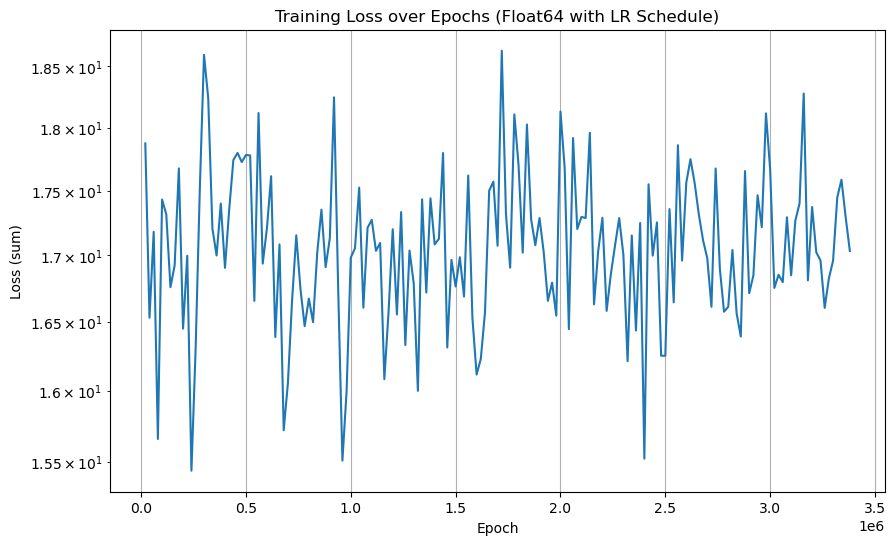

In [5]:
plt.figure(figsize=(10, 6))
plt.plot(epoch_nums, losses / num_samples)
plt.xlabel('Epoch')
plt.ylabel('Loss (sum)')
plt.title('Training Loss over Epochs (Float64 with LR Schedule)')
plt.grid(True)
plt.yscale('log')
plt.show()

In [6]:
pred = model(X).cpu().detach()



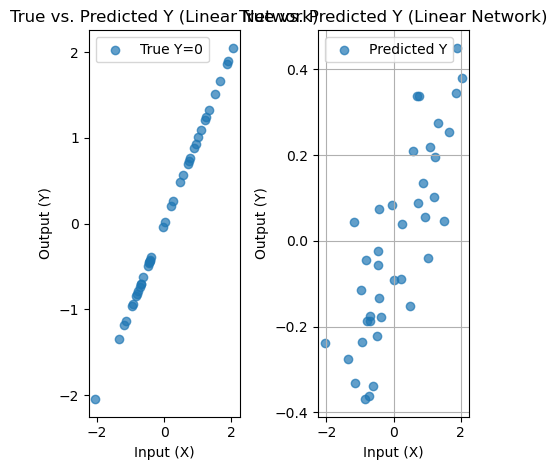

In [7]:
# 4. Visualize Results
model.eval() # Set model to evaluation mode
with torch.no_grad():
    predicted_Y = pred.mean(axis=2).numpy()

# plt.figure(figsize=(10, 5))
# plt.subplot(1, 3, 1)
# plt.plot(losses)
# plt.title('Loss over Epochs (Linear Network)')
# plt.xlabel('Epoch')
# plt.ylabel('MSE Loss')

plt.subplot(1, 3, 2)
plt.scatter(X[:,0].cpu().detach().numpy(), Y.cpu().detach().numpy(), label='True Y=0', alpha=0.7)
plt.title('True vs. Predicted Y (Linear Network)')
plt.xlabel('Input (X)')
plt.ylabel('Output (Y)')
plt.legend()

plt.subplot(1, 3, 3)
plt.scatter(X[:,0].cpu().detach().numpy(), predicted_Y, label='Predicted Y', alpha=0.7)
plt.title('True vs. Predicted Y (Linear Network)')
plt.xlabel('Input (X)')
plt.ylabel('Output (Y)')
plt.legend()

plt.grid(True)
plt.tight_layout()
plt.show()

# print("\nModel learned parameters (Linear Network with Langevin Dynamics):")
# for name, param in model.named_parameters():
#     if param.requires_grad:
#         print(f"{name}: {param.data.numpy()}")

In [8]:
y_tru = X[:,0].detach().cpu().numpy()
np.var((predicted_Y-y_tru)**2)

1.4827965538502383

In [9]:
P_inf = 5000
X_inf = torch.randn((P_inf, input_size), dtype=torch.float64, device=device)
Y_inf = X_inf
lH, lHstd = model.H_eig(X_inf, Y_inf, std = True)

torch.Size([600, 50, 20])


In [10]:
hh_inf_i.shape

NameError: name 'hh_inf_i' is not defined

In [11]:

# Kernel is averaged over ensemble and neuron indices
f_inf = model.h1_preactivation(X_inf)
hh_inf_i = torch.einsum('uim,vim->uvi', f_inf, f_inf)/(hidden_size * P_inf) #- torch.einsum('u,v->uv', fm_inf,fm_inf)
hh_inf = torch.sum(hh_inf_i, axis=2) / ens

norm = torch.einsum('ij,ij->j',X_inf.squeeze(), X_inf.squeeze()) / P_inf

Ls_i = torch.einsum('uj,uvi,vj->ij', X_inf.squeeze(), hh_inf_i, X_inf.squeeze()) / P_inf
lsT_i = Ls_i/norm

std_ls = torch.std(lsT_i, axis=0)


# Large matrix projection 
Ls = torch.einsum('uj,uv,vj->j', X_inf.squeeze(), hh_inf, X_inf.squeeze()) / P_inf



lsT = Ls/norm
lsT = lsT.detach().cpu().numpy()
lsT

array([0.02068147, 0.02097134, 0.02032161, 0.02168027, 0.0205446 ,
       0.02128755, 0.0202789 , 0.02135861, 0.0208286 , 0.02138892,
       0.02140027, 0.02054284, 0.02001804, 0.02145553, 0.02137237,
       0.02088861, 0.02095794, 0.02029578, 0.02026913, 0.02076609])

In [14]:
std_ls

tensor([0.0015, 0.0016, 0.0013, 0.0016, 0.0016, 0.0016, 0.0014, 0.0016, 0.0018,
        0.0019, 0.0016, 0.0015, 0.0016, 0.0016, 0.0015, 0.0020, 0.0013, 0.0017,
        0.0014, 0.0016], grad_fn=<StdBackward0>)

In [40]:
h1_kernel.sum(dim=(0,1))

tensor([0.0209, 0.0208, 0.0205, 0.0213, 0.0207, 0.0212, 0.0206, 0.0214, 0.0212,
        0.0212, 0.0213, 0.0208, 0.0204, 0.0213, 0.0212, 0.0210, 0.0203, 0.0206,
        0.0203, 0.0208], grad_fn=<SumBackward1>)

In [23]:
h1_kernel = contract('ul, uqk,  vqk, vl->l', Y_inf, f_inf,f_inf, Y_inf, backend='torch') / contract('ul, ul->l', Y_inf, Y_inf) / (ens * hidden_size* X_inf.shape[0])


In [25]:
h1_kernel = contract('ul, uqk,  vqk, vl->qkl', Y_inf, f_inf,f_inf, Y_inf, backend='torch') / contract('ul, ul->l', Y_inf, Y_inf) / (ens * hidden_size* X_inf.shape[0])


In [29]:
torch.sum(h1_kernel, dim = (0,1))

tensor([0.0209, 0.0208, 0.0205, 0.0213, 0.0207, 0.0212, 0.0206, 0.0214, 0.0212,
        0.0212, 0.0213, 0.0208, 0.0204, 0.0213, 0.0212, 0.0210, 0.0203, 0.0206,
        0.0203, 0.0208], grad_fn=<SumBackward1>)

In [ ]:

from opt_einsum import contract
W0 = model.W0.permute(*torch.arange(model.W0.dim() - 1, -1, -1))
W1 = model.W1.permute(*torch.arange(model.W1.dim() - 1, -1, -1))
covW0W1 = contract('kje,ije,nme,kme->in', W1,W0,W0,W1, backend='torch') / (hidden_size * ens)
y = covW0W1.diagonal().detach().cpu().numpy().tolist()


In [16]:
W0 = model.W0.permute(*torch.arange(model.W0.dim() - 1, -1, -1))
W0.shape


torch.Size([20, 600, 50])

In [17]:
torch.std(contract('inq,jnq->nqij',W0,W0).diagonal(dim1=2, dim2=3), dim=(0,1))

tensor([0.0714, 0.0694, 0.0706, 0.0703, 0.0711, 0.0708, 0.0702, 0.0707, 0.0706,
        0.0706, 0.0692, 0.0724, 0.0714, 0.0715, 0.0700, 0.0708, 0.0715, 0.0717,
        0.0696, 0.0704], grad_fn=<StdBackward0>)

In [18]:
cov_W0 = contract('inq,jnq->ij',W0,W0)/(hidden_size * ens)
lsT = cov_W0.diag().detach().cpu().numpy()
stds =  torch.std(contract('inq,jnq->nqij',W0,W0).diagonal(dim1=-2, dim2=-1), dim = (0,1)).detach().cpu().numpy()


array([0.07144523, 0.06938056, 0.07055253, 0.07028107, 0.07107289,
       0.07078355, 0.07021246, 0.07071814, 0.07059477, 0.07056387,
       0.06921733, 0.07241228, 0.07142263, 0.0715299 , 0.0700406 ,
       0.0707504 , 0.07152522, 0.07169241, 0.06958631, 0.07042128])

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import matplotlib.font_manager as fm

# Use std_ls for error bars
x = range(len(lsT))  # x-axis indices
lsT_arr = np.array(lH)
std_ls_arr = np.array(lHstd)

# Set a parchment-like background
fig = plt.figure(figsize=(10, 6), facecolor='#f5e8c7')  # Parchment beige
ax = fig.add_subplot(111, facecolor='#f5e8c7')
ax.set_facecolor('#f5e8c7')

# Add texture to simulate parchment imperfections
ax.add_patch(Rectangle((0, 0), 1, 1, transform=ax.transAxes, zorder=0, 
                       facecolor='#e8d9b9', alpha=0.3, linewidth=0))

# Plot data with a pencil-sketch style and error bars
bars = ax.bar(x, lsT_arr, color='#8B4513', edgecolor='#5c4033', linewidth=1.5, 
              alpha=0.8, zorder=3, yerr=std_ls_arr, capsize=5, error_kw=dict(ecolor='#a68a64', lw=2, alpha=0.7, capthick=2))

# Add nib-pen effect to edges
for bar in bars:
    bar.set_linewidth(1.5)
    bar.set_edgecolor('#5c4033')
    height = bar.get_height()
    ax.plot([bar.get_x() + bar.get_width()/2, bar.get_x() + bar.get_width()/2], 
            [0, height], color='#5c4033', linestyle='-', linewidth=1.2, alpha=0.7)
    
# Customize axes and labels with a handwritten font
try:
    handwritten_font = fm.FontProperties(fname='/home/akiva/fonts/EBGaramond.ttf')  # Replace with a real path to a font like 'Great Vibes'
except:
    handwritten_font = None  # Fallback if font not found

if handwritten_font:
    plt.xlabel('Index', fontproperties=handwritten_font, color='#5c4033', fontsize=14)
    plt.ylabel('Eigenvalue Magnitude', fontproperties=handwritten_font, color='#5c4033', fontsize=14)
    plt.title("Eigenvalues of $K_{\\mu\\nu}$" + f'- N:{hidden_size},P:{num_samples},D:{input_size}, chi=N', fontproperties=handwritten_font, color='#5c4033', fontsize=16, pad=15)
else:
    plt.xlabel('Index', fontstyle='italic', color='#5c4033', fontsize=14)
    plt.ylabel('Eigenvalue Magnitude', fontstyle='italic', color='#5c4033', fontsize=14)
    plt.title('Eigenvalues of $K_{\\mu \\nu}$', fontstyle='italic', color='#5c4033', fontsize=16, pad=15)
    
# Add grid with a faint, irregular pencil look
ax.grid(True, linestyle='--', linewidth=0.5, color='#a68a64', alpha=0.4, zorder=1)

ltarg = 0.219
Ymax = max(lsT_arr.tolist()+[ltarg])*1.1

# Set axis limits and ticks with an aged style
ax.set_ylim(0, Ymax)  # Adjusted to 10% above max(y) for better fit

ax.set_xticks(x)
ax.set_yticks(np.arange(0, Ymax, step=0.05))  # Finer ticks, adjusted to new limit
ax.tick_params(axis='both', colors='#5c4033', labelsize=12)

# Add a decorative border
for spine in ax.spines.values():
    spine.set_visible(True)
    spine.set_color('#5c4033')
    spine.set_linewidth(1.5)
    spine.set_alpha(0.8)

# Add a faux signature or note in the corner
ax.text(0.95, 0.05, 'Scribbled by J. Smith, 1785', transform=ax.transAxes, 
        color='#5c4033', fontsize=10, ha='right', va='bottom', alpha=0.7)
ax.axhline(y=ltarg, color='red', linestyle='--')

ax.text(x=3, y=ltarg + 0.001, s=f'$\lambda_* = {ltarg}$', fontsize=12, ha='center', fontstyle="italic",  color='#5c4033', fontproperties=handwritten_font)
ax.axhline(y=0.05, color='red', linestyle='--')
ax.text(x=5, y=0.05 + 0.008, s='$\lambda_p = 1/20= 0.05$', fontsize=12, ha='center', fontstyle="italic",  color='#5c4033', fontproperties=handwritten_font)

# Adjust layout to avoid clipping
plt.tight_layout()

# Show the plot
plt.show()

RuntimeError: Can't call numpy() on Tensor that requires grad. Use tensor.detach().numpy() instead.

In [59]:
lH

tensor([0.0025, 0.0025, 0.0025, 0.0026, 0.0026, 0.0025, 0.0025, 0.0025, 0.0025,
        0.0026, 0.0025, 0.0025, 0.0025, 0.0024, 0.0024, 0.0024, 0.0025, 0.0024,
        0.0025, 0.0025], grad_fn=<MeanBackward1>)

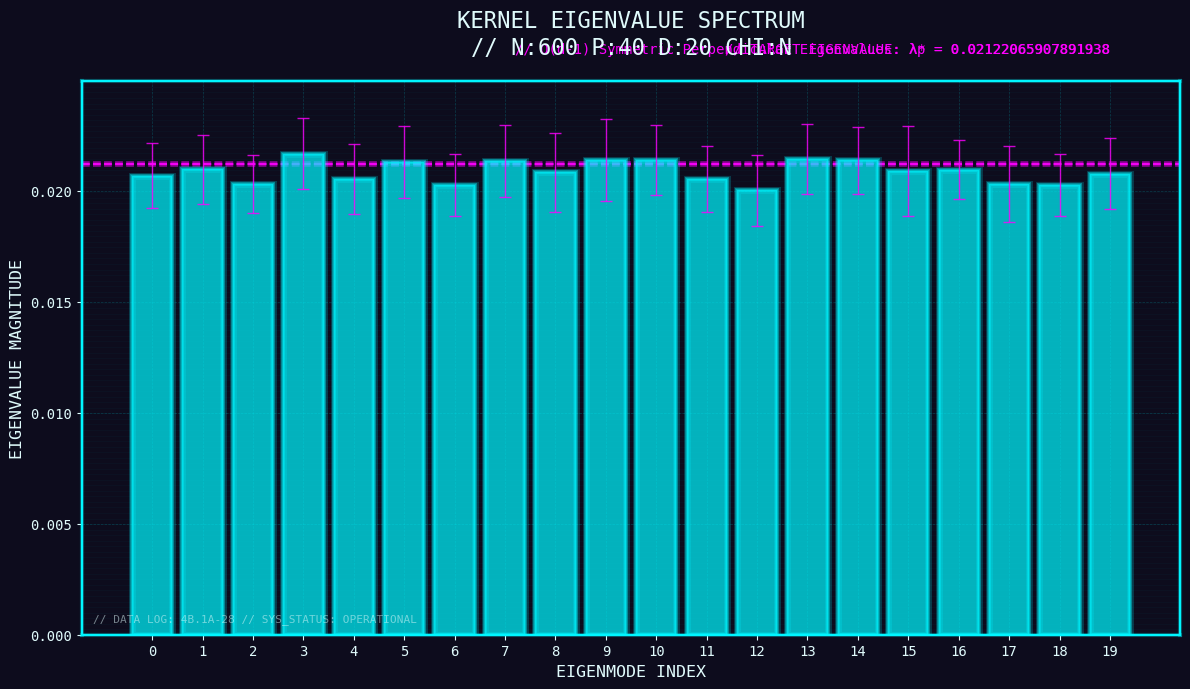

In [17]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import matplotlib.font_manager as fm
import matplotlib.patheffects



lHnp = lsT#.cpu().detach().numpy()
lHstdnp = std_ls.cpu().detach().numpy()
# Use std_ls for error bars
x = range(len(lHnp))  # x-axis indices
lsT_arr = np.array(lHnp)
std_ls_arr = np.array(lHstdnp)

# --- AESTHETIC SETUP: Sci-Fi Retro ---
BG_COLOR = '#0d0c1d'       # Deep midnight blue
PRIMARY_COLOR = '#00f6ff'  # Bright cyan
ACCENT_COLOR = '#ff00ff'   # Electric magenta
TEXT_COLOR = '#e0fbfc'     # Off-white/light cyan
GRID_COLOR = '#00f6ff'
ERROR_BAR_COLOR = '#ff00ff'

# --- Font Setup ---
# Attempt to use a futuristic or monospaced font. 'Share Tech Mono' is a great free option.
# Download from Google Fonts: https://fonts.google.com/specimen/Share+Tech+Mono
try:
    # IMPORTANT: Replace with the actual path to your font file if you have one
    # sci_fi_font = fm.FontProperties(fname='/path/to/your/font/ShareTechMono-Regular.ttf')
    sci_fi_font = fm.FontProperties(family='monospace') # A reliable fallback
except:
    sci_fi_font = fm.FontProperties(family='monospace')

# --- Plot Setup ---
fig = plt.figure(figsize=(12, 7), facecolor=BG_COLOR)
ax = fig.add_subplot(111, facecolor=BG_COLOR)

# --- Background Effects: Grid and Scanlines ---
# Add a faint grid to look like a computer display
ax.grid(True, which='major', color=GRID_COLOR, linestyle='--', linewidth=0.5, alpha=0.2, zorder=0)

# Add faint horizontal "scanlines" for a CRT monitor effect
# THIS IS THE CORRECTED PART
for y_pos in np.arange(0, 1, 0.01):
    ax.plot([0, 1], [y_pos, y_pos], color=PRIMARY_COLOR, linewidth=0.5, alpha=0.03, zorder=0, transform=ax.transAxes)

# --- Plot Data: Holographic Bars with Glow ---
# The main bars
bars = ax.bar(x, lsT_arr, color=PRIMARY_COLOR, edgecolor=PRIMARY_COLOR, linewidth=1.5,
              alpha=0.4, zorder=3, yerr=std_ls_arr, capsize=4,
              error_kw=dict(ecolor=ERROR_BAR_COLOR, lw=1, capthick=1, alpha=0.8))

# Add a glow effect to the bars
for bar in bars:
    bar.set_path_effects([
        matplotlib.patheffects.Stroke(linewidth=5, foreground=PRIMARY_COLOR, alpha=0.2),
        matplotlib.patheffects.Stroke(linewidth=3, foreground=PRIMARY_COLOR, alpha=0.4),
        matplotlib.patheffects.Normal()
    ])

scale = 4 / ( 3 * np.pi)
# --- Title and Labels: System Readout Style ---
ax.set_title(
    f"KERNEL EIGENVALUE SPECTRUM\n// N:{hidden_size} P:{num_samples} D:{input_size} CHI:N",
    fontproperties=sci_fi_font, color=TEXT_COLOR, fontsize=16, pad=20
)
ax.set_xlabel('EIGENMODE INDEX', fontproperties=sci_fi_font, color=TEXT_COLOR, fontsize=12)
ax.set_ylabel('EIGENVALUE MAGNITUDE', fontproperties=sci_fi_font, color=TEXT_COLOR, fontsize=12)

# --- Axes, Ticks, and Spines ---
ltarg = (1/input_size) * scale
Ymax = max(lsT_arr.tolist() + [ltarg]) * 1.15
ax.set_ylim(0, Ymax)
ax.set_xticks(x)
ax.tick_params(axis='both', colors=TEXT_COLOR, labelsize=10)
for label in ax.get_xticklabels() + ax.get_yticklabels():
    label.set_fontproperties(sci_fi_font)

# Style the plot borders (spines) to glow
for spine in ax.spines.values():
    spine.set_color(PRIMARY_COLOR)
    spine.set_linewidth(1.5)
    spine.set_path_effects([
        matplotlib.patheffects.Stroke(linewidth=3, foreground=PRIMARY_COLOR, alpha=0.3),
        matplotlib.patheffects.Normal()
    ])


# --- Threshold Lines and Annotations ---
# Plot glowing threshold lines
ax.axhline(y=ltarg, color=ACCENT_COLOR, linestyle='--', linewidth=1.5, alpha=0.7, zorder=2,
            path_effects=[matplotlib.patheffects.Stroke(linewidth=4, foreground=ACCENT_COLOR, alpha=0.3),
                          matplotlib.patheffects.Normal()])
ax.text(x=len(x) - 1, y=ltarg + 0.005, s=f'// TARGET EIGENVALUE: λ* = {ltarg}',
        fontproperties=sci_fi_font, color=ACCENT_COLOR, fontsize=10, ha='right')

lambda_p = 0.05 * scale
ax.axhline(y=lambda_p, color=ACCENT_COLOR, linestyle='--', linewidth=1.5, alpha=0.7, zorder=2,
            path_effects=[matplotlib.patheffects.Stroke(linewidth=4, foreground=ACCENT_COLOR, alpha=0.3),
                          matplotlib.patheffects.Normal()])
ax.text(x=len(x) - 1, y=lambda_p + 0.005, s=f'// O(d-1) Symmetric Perpendicular Eigenvalues: λp = {lambda_p}',
        fontproperties=sci_fi_font, color=ACCENT_COLOR, fontsize=10, ha='right')


# --- Final Touches: System Log ---
ax.text(0.01, 0.02, '// DATA LOG: 4B.1A-28 // SYS_STATUS: OPERATIONAL',
        transform=ax.transAxes, fontproperties=sci_fi_font,
        color=TEXT_COLOR, alpha=0.5, fontsize=8, ha='left', va='bottom')

plt.tight_layout()
plt.show()

In [40]:
lsT.tolist() + [.419]

[0.2073408475204422,
 0.051499661532764154,
 0.05085717399758604,
 0.05495549949152261,
 0.05038317393514154,
 0.05207461084891398,
 0.0488609832113846,
 0.05466223537904256,
 0.051028326489442284,
 0.051305528143967744,
 0.05266633082950962,
 0.05214521573280133,
 0.05162766339241314,
 0.052113865548968845,
 0.05031086755222682,
 0.052118509197291385,
 0.04899279093077151,
 0.06578743152056667,
 0.05346969088206605,
 0.05256168253532499,
 0.419]

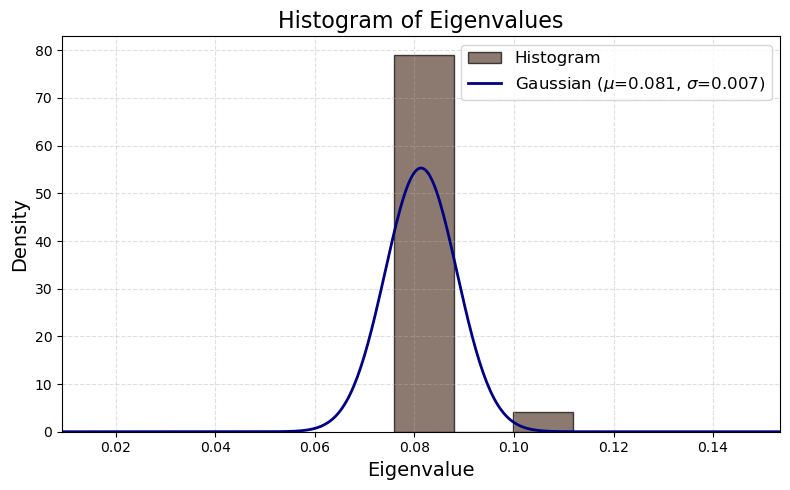

In [42]:
# Plot the histogram of the eigenvalues and overlay a Gaussian fit
import numpy as np
from scipy.stats import norm

eigenvalues = y
mean = np.mean(eigenvalues)
std = np.std(eigenvalues)

plt.figure(figsize=(8, 5))
# Plot histogram
counts, bins, patches = plt.hist(eigenvalues, bins=3, color='#5c4033', alpha=0.7, edgecolor='black', density=True, label='Histogram')

# Overlay Gaussian
# Set x limits far from the mean to emphasize the narrowness
xlim_pad = 10  # how many stds to pad on each side
x_min = mean - xlim_pad * std
x_max = mean + xlim_pad * std
x = np.linspace(x_min, x_max, 400)
pdf = norm.pdf(x, mean, std)
plt.plot(x, pdf, color='navy', linewidth=2, label=f'Gaussian ($\\mu$={mean:.3f}, $\\sigma$={std:.3f})')

plt.xlabel('Eigenvalue', fontsize=14)
plt.ylabel('Density', fontsize=14)
plt.title('Histogram of Eigenvalues', fontsize=16)
plt.grid(True, linestyle='--', alpha=0.4)
plt.legend(fontsize=12)
plt.xlim(x_min, x_max)
plt.tight_layout()
plt.show()

In [43]:
losses

array([145.24236037, 139.52198146, 135.21983603, 130.08604029,
       125.47242027, 121.29294844, 117.6878342 , 113.893784  ,
       109.98220941, 106.71826585, 103.46336316, 101.17722142,
        97.61657394,  94.86406947,  92.9799073 ,  89.33813349,
        87.32173253,  86.42627129,  83.55865905,  82.5461606 ,
        80.10963727,  78.0632102 ,  76.36523891,  74.74391947,
        73.3913644 ,  72.01364941,  70.91725497,  69.50723108,
        68.46452357,  66.59878878,  65.33054497,  64.54091109,
        63.73588336,  63.08463108,  61.42861373,  60.81258523,
        59.85536671,  58.71789996,  57.91049948,  56.76801824,
        56.0779108 ,  55.71827063,  54.79328392,  54.38617479,
        53.54890313,  52.6903891 ,  52.4692266 ,  51.32005436,
        50.8573814 ,  50.43853251,  50.15992044,  48.88982971,
        48.71802397,  48.93317273,  48.05651071,  47.08230285,
        47.14521044,  46.6733864 ,  45.86665207,  45.88259474,
        45.28493762,  44.83193312,  44.20829114,  43.77

In [44]:
np.mean(ls)

0.08131752598306402

In [45]:
np.std(ls)

0.007212632036172995

In [46]:
epoch > 2_000_000 * 0.8

True

In [47]:
import sys
sys.path.append('/home/akiva/FCNX-Ensembling/')

from GPKit import *
true_gpr = gpr_dot_product_explicit(X, Y, X, 1.0).cpu().detach()
prediction = model(X).cpu().detach().mean(-1)
tru_y =  Y.cpu().cpu().detach()
prediction.shape

torch.Size([20, 1])

tru_y_np shape: (20, 1)
true_gpr_np shape: (20, 1)
prediction_np_cpu shape: (20, 1)
X_np shape: (20, 20)
MSE similarity between true_gpr_np and prediction_np: -0.0021330808063341634
MSE similarity between prediction_np and tru_y_np: -0.005210962735073663
MSE similarity between true_gpr_np and tru_y: -0.007344043541407827


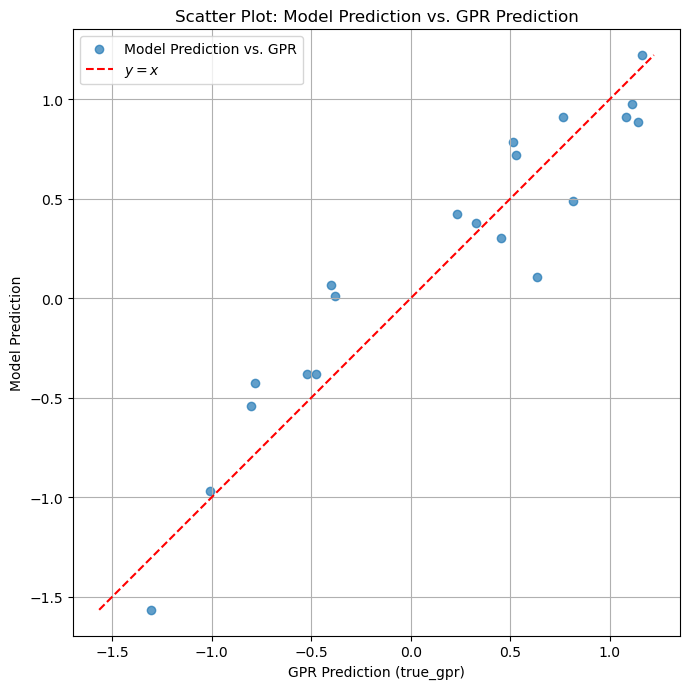

In [48]:


# Move all data to CPU numpy arrays
tru_y_np = tru_y.numpy() if hasattr(tru_y, 'cpu') else tru_y
true_gpr_np = true_gpr.cpu().numpy() if hasattr(true_gpr, 'cpu') else true_gpr
prediction_np = prediction.cpu().numpy() if hasattr(prediction, 'cpu') else prediction
X_np = X.cpu().detach().numpy() if hasattr(X, 'cpu') else X

# Print shapes of all these arrays/tensors
print("tru_y_np shape:", getattr(tru_y_np, "shape", "no shape"))
print("true_gpr_np shape:", getattr(true_gpr_np, "shape", "no shape"))
print("prediction_np_cpu shape:", getattr(prediction_np, "shape", "no shape"))
print("X_np shape:", getattr(X_np, "shape", "no shape"))



def cosine_similarity(a, b):
    """
    Compute the cosine similarity between two numpy arrays.
    """
    a_flat = a.ravel()
    b_flat = b.ravel()
    numerator = np.dot(a_flat, b_flat)
    denominator = np.linalg.norm(a_flat) * np.linalg.norm(b_flat)
    cossim = numerator / denominator if denominator != 0 else np.nan
    return np.arccos(cossim) * 180 / np.pi 

def me(a,b):
    return np.mean((a - b))  / num_samples

# Compute cosine similarity between true_gpr_np and prediction_np

mse_nn_gpr = me(true_gpr_np, prediction_np) 
print("MSE similarity between true_gpr_np and prediction_np:", mse_nn_gpr)

# Compute cosine similarity between true_gpr_np and tru_y
mse_nn_truy = me(prediction_np, tru_y_np) 
print("MSE similarity between prediction_np and tru_y_np:", mse_nn_truy)

# Compute cosine similarity between true_gpr_np and tru_y
mse_gpr_truy = me(true_gpr_np, tru_y_np) 
print("MSE similarity between true_gpr_np and tru_y:", mse_gpr_truy)
import matplotlib.pyplot as plt
import numpy as np

# Ensure prediction is a numpy array for plotting
if hasattr(prediction, "detach"):
    prediction_np = prediction.detach().cpu().numpy()
else:
    prediction_np = np.array(prediction)

# Flatten arrays if needed for scatter plot
gpr_flat = true_gpr.flatten()
pred_flat = prediction_np.flatten()

plt.figure(figsize=(7, 7))
plt.scatter(gpr_flat, pred_flat, alpha=0.7, label='Model Prediction vs. GPR')
min_val = min(gpr_flat.min(), pred_flat.min())
max_val = max(gpr_flat.max(), pred_flat.max())
plt.plot([min_val, max_val], [min_val, max_val], 'r--', label='$y=x$')
plt.xlabel('GPR Prediction (true_gpr)')
plt.ylabel('Model Prediction')
plt.title('Scatter Plot: Model Prediction vs. GPR Prediction')
plt.legend()
plt.axis('equal')  # Keep x and y axis with the same scale
plt.grid(True)
plt.tight_layout()
plt.show()


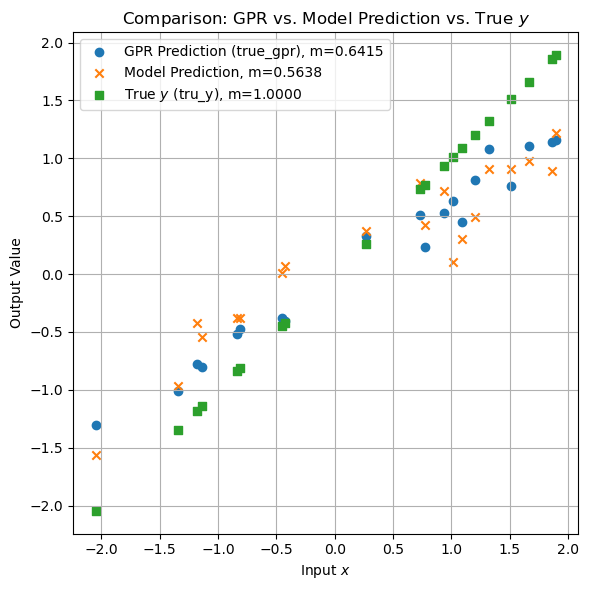

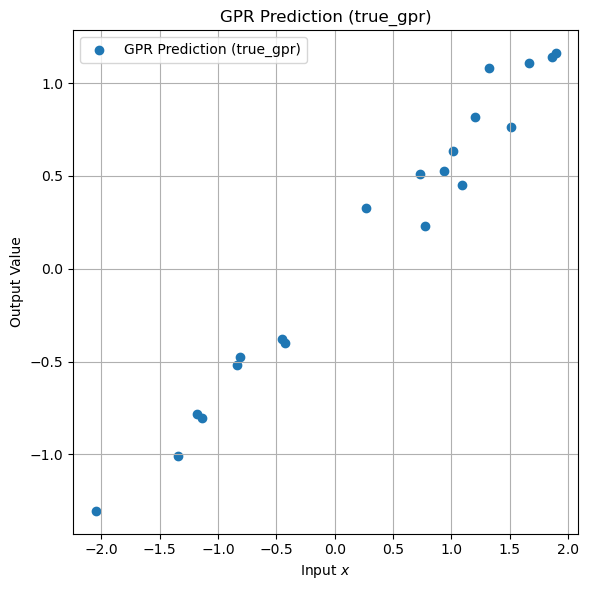

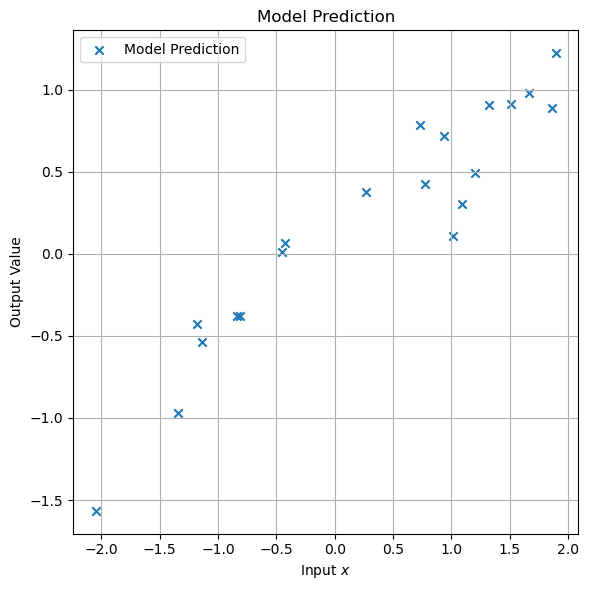

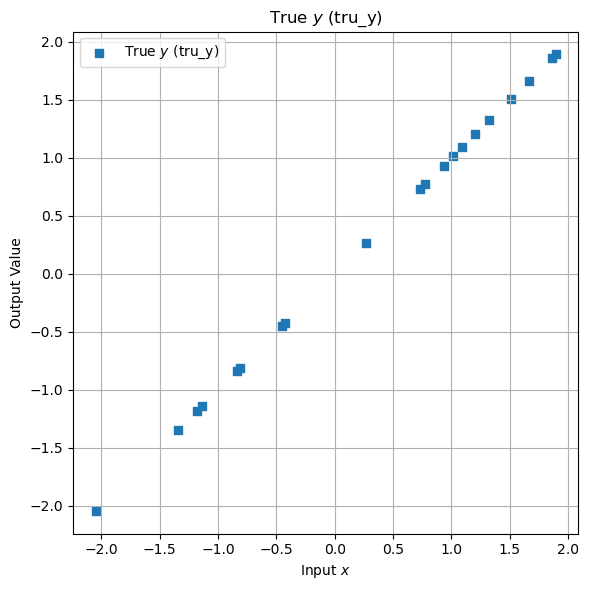

In [49]:
slope = lambda x, y: np.polyfit(x, y, 1)[0].item() if len(x) == len(y) else None
import matplotlib.pyplot as plt
import numpy as np

# Ensure prediction is a numpy array for plotting
if hasattr(prediction, "detach"):
    prediction_np = prediction.detach().cpu().numpy()
else:
    prediction_np = np.array(prediction)

# Use x[:,0] as the x-axis for plotting
if hasattr(X, "detach"):
    x_plot = X.detach().cpu().numpy()
else:
    x_plot = np.array(X)
x_axis = x_plot[:,0] if x_plot.ndim > 1 else x_plot

# Plot comparison of true_gpr, prediction, and tru_y
plt.figure(figsize=(6, 6))
s1 = slope(x_axis, true_gpr)
s2 = slope(x_axis, prediction_np[:, 0] if prediction_np.ndim > 1 else prediction_np)
s3 = slope(x_axis, tru_y[:, 0] if tru_y.ndim > 1 else tru_y)
plt.scatter(x_axis, true_gpr, label=f'GPR Prediction (true_gpr), m={s1:.4f}', marker='o')
plt.scatter(x_axis, prediction_np[:, 0] if prediction_np.ndim > 1 else prediction_np, label=f'Model Prediction, m={s2:.4f}', marker='x')
plt.scatter(x_axis, tru_y[:, 0] if tru_y.ndim > 1 else tru_y, label=f'True $y$ (tru_y), m={s3:.4f}', marker='s')


plt.xlabel('Input $x$')
plt.ylabel('Output Value')
plt.title('Comparison: GPR vs. Model Prediction vs. True $y$')
plt.legend()
plt.grid(True)
plt.tight_layout()
# Plot each curve in a separate figure, one beneath the other

# Plot 1: GPR Prediction (true_gpr)
plt.figure(figsize=(6, 6))
plt.scatter(x_axis, true_gpr, label='GPR Prediction (true_gpr)', marker='o')
plt.xlabel('Input $x$')
plt.ylabel('Output Value')
plt.title('GPR Prediction (true_gpr)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Plot 2: Model Prediction
plt.figure(figsize=(6, 6))
plt.scatter(x_axis, prediction_np[:,0] if prediction_np.ndim > 1 else prediction_np, label='Model Prediction', marker='x')
plt.xlabel('Input $x$')
plt.ylabel('Output Value')
plt.title('Model Prediction')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Plot 3: True y (tru_y)



plt.figure(figsize=(6, 6))
plt.scatter(x_axis, tru_y[:,0] if tru_y.ndim > 1 else tru_y, label='True $y$ (tru_y)', marker='s')
plt.xlabel('Input $x$')
plt.ylabel('Output Value')
plt.title('True $y$ (tru_y)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [50]:
getslope = lambda x, y: np.polyfit(x, y, 1)[0].item() if len(x) == len(y) else None

import os
import torch
import re
import matplotlib.pyplot as plt
import numpy as np
from numpy.linalg import norm


model_dir = file
epochs = []
slopes = []
cosine_similarities = []
X.requires_grad_(True)

for filename in os.listdir(model_dir):
    if filename.startswith("model_epoch_") and filename.endswith(".pth"):
        filepath = os.path.join(model_dir, filename)
        match = re.search(r"model_epoch_(\d+)\.pth", filename)
        if match:
            epoch = int(match.group(1))
            epochs.append(epoch)
            model.load_state_dict(torch.load(filepath, map_location=device))
            model.eval()
            X_clone = X.clone()
            output = model(X_clone).mean(axis=-1).to('cpu').detach().numpy()
            slope = getslope(true_gpr_np[:,0], output[:,0])
            slopes.append(slope)
            # Compute cosine similarity of model output against true_gpr_np
            model_output_flat = output.flatten()
            true_gpr_flat = true_gpr_np[:,0].flatten()
            cosine_similarity = np.dot(model_output_flat, true_gpr_flat) / (norm(model_output_flat) * norm(true_gpr_flat))
            cosine_similarities.append(cosine_similarity)




In [51]:
sorted_indices = np.argsort(epochs)
epochs_sorted = np.array(epochs)[sorted_indices]
slopes_sorted = np.array(slopes)[sorted_indices]
cos_sorted = np.array(cosine_similarities)[sorted_indices]

In [52]:
true_slope = getslope(X.to('cpu').detach().numpy()[:,0], Y.to('cpu').detach().numpy())
m_gpr = getslope(true_gpr_np[:,0], true_gpr_np[:,0])

In [53]:
tosave = {'Indices': sorted_indices, 'Epochs': epochs_sorted, 'Predicted Slopes':slopes_sorted, 'Cosine Similarity': cos_sorted }
import pickle
with open(os.path.join(file, 'gp_comparison_metrics_over_time'), 'wb') as f:
    pickle.dump(tosave, f)

Text(0.02, 0.98, 'Recorded on 20250722_103350')

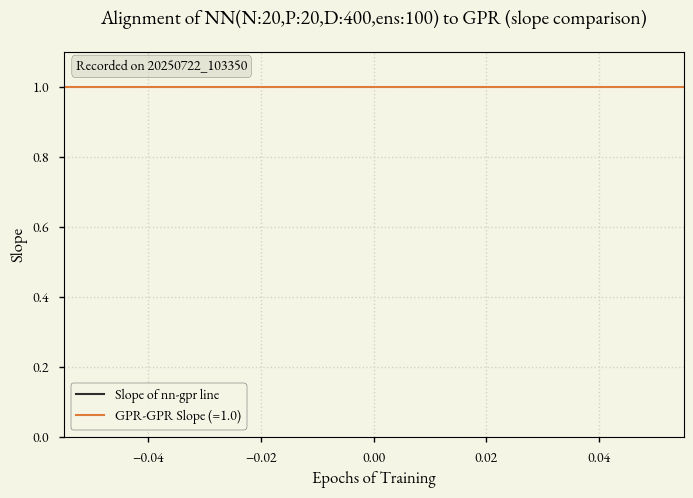

In [54]:
# Ensure Matplotlib recognizes the custom font
from matplotlib import font_manager
font_path = '/home/akiva/fonts/EBGaramond.ttf'
font_manager.fontManager.addfont(font_path)
plt.rcParams['font.family'] = 'EB Garamond'

# Custom Victorian style
plt.style.use('seaborn-v0_8-notebook')
plt.rcParams.update({
    'font.size': 12,
    'axes.facecolor': '#f5f5e6',  # Parchment background
    'figure.facecolor': '#f5f5e6',
    'grid.color': '#d4d4c4',
    'grid.linestyle': ':',
    'lines.linewidth': 1.5,
})

plt.figure(figsize=(8, 5))
plt.plot(epochs_sorted, slopes_sorted, marker='x', linestyle='-', color='#2e2e2e', label='Slope of nn-gpr line')
# plt.axhline(y=true_slope, color='#355e3b', linestyle='--', label=f'True Slope = {true_slope:.2f}')
plt.axhline(y=m_gpr, color='#e07b39', linestyle='-', label='GPR-GPR Slope (=1.0)')
plt.title('Alignment of NN(N:20,P:20,D:400,ens:100) to GPR (slope comparison)', fontsize=14, pad=20)
plt.xlabel('Epochs of Training', fontsize=12)
plt.ylabel('Slope', fontsize=12)
plt.ylim(0, 1.1)
plt.grid(True)
from datetime  import datetime
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
plt.legend(frameon=True, framealpha=0.9, edgecolor='#2e2e2e')
plt.text(0.02, 0.98, f'Recorded on {timestamp}', transform=plt.gca().transAxes, fontsize=10, 
         verticalalignment='top', bbox=dict(boxstyle='round', facecolor='#d4d4c4', alpha=0.5))
# plt.savefig(os.path.join(save_dir, f"slope_epoch_{epoch+1}.png"), dpi=300, bbox_inches='tight')
# writer.add_figure('Slope/Over_Epochs', plt.gcf(), global_step=epoch)
# plt.close()

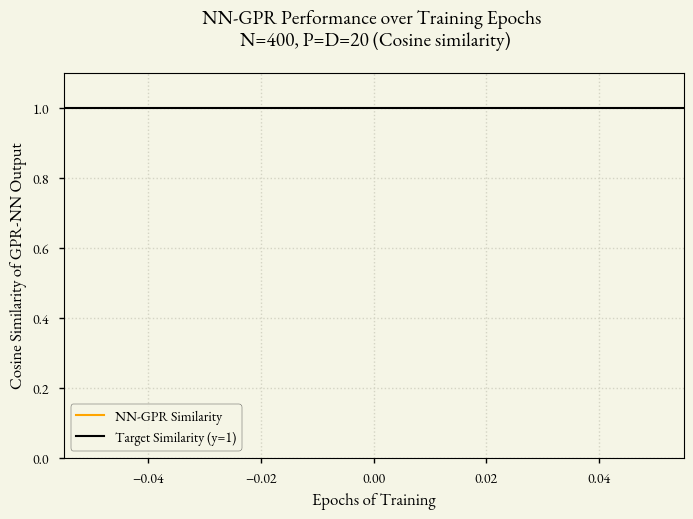

In [55]:
plt.figure(figsize=(8, 5))
plt.plot(epochs_sorted, cos_sorted, linestyle='-', color='orange', label='NN-GPR Similarity')
plt.axhline(y=1.0, color='black', linestyle='-', linewidth=1.5, label='Target Similarity (y=1)')
plt.title('NN-GPR Performance over Training Epochs \n N=400, P=D=20 (Cosine similarity)', fontsize=14, pad=20)
plt.xlabel('Epochs of Training', fontsize=12)
plt.ylabel('Cosine Similarity of GPR-NN Output', fontsize=12)
plt.ylim(0, 1.1)
plt.grid(True)
plt.legend(frameon=True, framealpha=0.9, edgecolor='#2e2e2e')
plt.show()

In [23]:
1

1